<a href="https://colab.research.google.com/github/3lson/ASLModelProj/blob/main/ASLModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASLModel Training

This notebook will be used to train this model due to the TPU option available on google colab making it faster to run as opposed to the architecture on my local machine

## Uploading the data

In [2]:
#Download dependencies
!pip install opencv-python


In [3]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -q /content/drive/MyDrive/MLmodels/ASLModel/data.zip

Mounted at /content/drive


## Testing the data directory

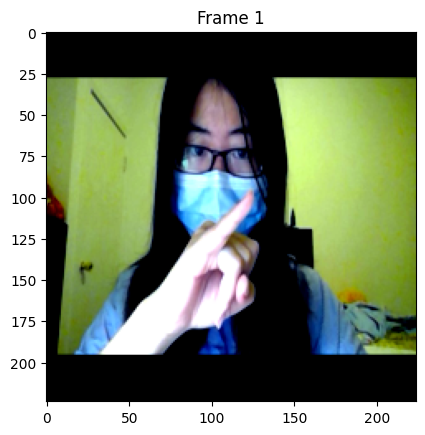

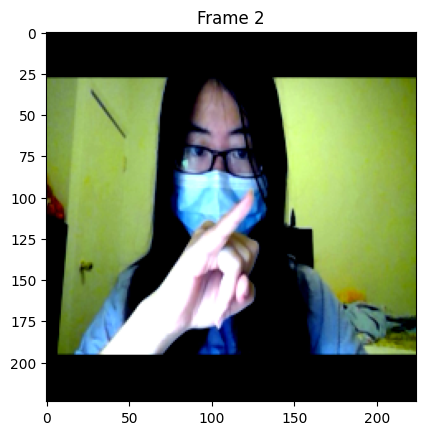

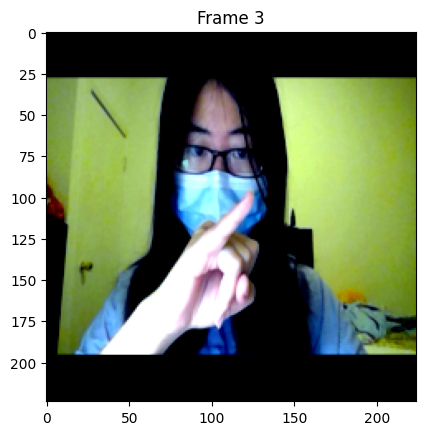

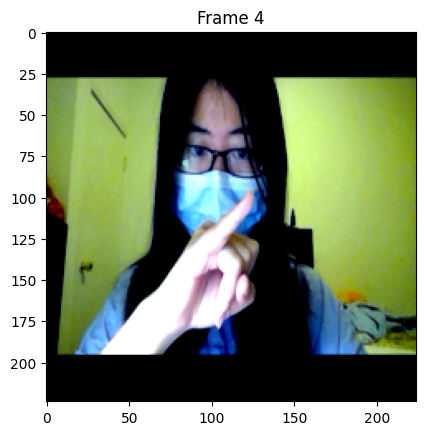

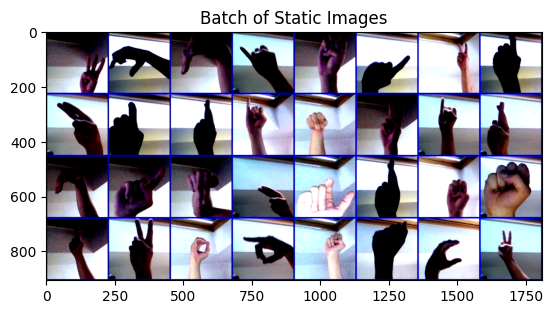

In [5]:
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
from PIL import Image

# Define image transformations (used for both images and video frames)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom Dataset for Video Loading
class VideoDataset(Dataset):
    def __init__(self, video_dir, transform=None, frame_count=16):
        self.video_dir = video_dir
        self.transform = transform
        self.frame_count = frame_count
        self.video_files = [os.path.join(video_dir, f) for f in os.listdir(video_dir) if f.endswith('.avi') or f.endswith('.mp4')]

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        sample_interval = max(1, frame_total // self.frame_count)

        for i in range(self.frame_count):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * sample_interval)
            ret, frame = cap.read()
            if not ret:
                break

            # Convert the frame (NumPy array) to PIL Image
            frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            frame = self.transform(frame) if self.transform else torch.tensor(frame)
            frames.append(frame)

        cap.release()
        video_tensor = torch.stack(frames)
        return video_tensor, idx  # Replace idx with actual label when available

# Load and preprocess video data
video_train_path = '/content/data/video_data/J'  # Specify your path to video data
video_data = VideoDataset(video_train_path, transform=transform, frame_count=16)
video_loader = DataLoader(video_data, batch_size=4, shuffle=True)

# Load and preprocess static image data (like before)
train_path = '/content/data/static_images/asl_alphabet_train/asl_alphabet_train/'
train_data = datasets.ImageFolder(train_path, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Get a batch of videos
video_iter = iter(video_loader)
videos, video_labels = next(video_iter)

# Get a batch of images
image_iter = iter(train_loader)
images, image_labels = next(image_iter)

# Function to display video frames (show first frame)
def imshow_video(video_tensor, n_frames=4):
    frames = video_tensor[0]  # Get the first video from the batch
    for i in range(min(n_frames, frames.shape[0])):  # Display the first n frames
        img = frames[i] / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(f"Frame {i+1}")
        plt.show()

# Function to display images (for static images)
def imshow_images(images_batch):
    img = images_batch / 2 + 0.5  # unnormalize
    npimg = torchvision.utils.make_grid(img).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('Batch of Static Images')
    plt.show()

# Display both
imshow_video(videos, n_frames=4) # Display the first frame of the first video
imshow_images(images)  # Display the batch of static images


## Train the model

In [9]:
import torch
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms, datasets
from sklearn.metrics import accuracy_score
import signal
import sys
import os
import cv2
from torch.utils.data import Dataset
from PIL import Image

# Video Dataset Class (For J and Z videos only)
class VideoDataset(Dataset):
    def __init__(self, video_dir, transform=None, frame_count=8):
        self.video_dir = video_dir
        self.transform = transform
        self.frame_count = frame_count

        # Map J and Z to their corresponding indices in the static data classes
        self.class_to_idx = {'J': 9, 'Z': 25}  # Indices for J and Z in A-Z alphabet

        # Gather video files and their corresponding labels
        self.video_files = []
        self.labels = []

        for class_name in ['J', 'Z']:  # Only handle 'J' and 'Z'
            class_path = os.path.join(video_dir, class_name)
            for video_file in os.listdir(class_path):
                if video_file.endswith('.avi'):
                    self.video_files.append(os.path.join(class_path, video_file))
                    self.labels.append(self.class_to_idx[class_name])  # Get corresponding class index

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        sample_interval = max(1, frame_total // self.frame_count)

        for i in range(self.frame_count):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * sample_interval)
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            frame = Image.fromarray(frame)  # Convert to PIL image

            if self.transform:
                frame = self.transform(frame)  # Apply transformations

            frames.append(frame)

        cap.release()

        # Stack frames to create a tensor of shape (frame_count, 3, 224, 224)
        video_tensor = torch.stack(frames)
        return video_tensor, self.labels[idx]  # Return the actual label for the video (J or Z)

# Define image transformations
print("Setting up data transformations...")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess static image data
print("Loading static image datasets...")
train_path = '/content/data/static_images/asl_alphabet_train/asl_alphabet_train/'
train_data = datasets.ImageFolder(train_path, transform=transform)

# Load and preprocess video data (J and Z only)
video_train_path = '/content/data/video_data/'
video_data = VideoDataset(video_train_path, transform=transform, frame_count=8)

# Combine static image and video datasets into one training dataset
combined_data = ConcatDataset([train_data, video_data])

# Custom collate function to handle mixed data shapes
def custom_collate(batch):
    videos = []
    labels = []
    for data, label in batch:
        if len(data.shape) == 3:  # Static images (3, 224, 224)
            data = data.unsqueeze(0).repeat(8, 1, 1, 1)  # Add frame dimension and repeat for 8 frames
        videos.append(data)
        labels.append(label)
    return torch.stack(videos), torch.tensor(labels)

# Create a DataLoader with the custom collate function
combined_loader = DataLoader(combined_data, batch_size=16, shuffle=True, collate_fn=custom_collate)

# Load pre-trained ResNet18 model
print("Setting up the model...")
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(train_data.classes))  # Number of classes (A-Z = 26)

# Check for MPS (Apple Silicon GPU support) or CPU fallback
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f"Using device: {device}")
model.to(device)

# Set up loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define a function to save the model
def save_model():
    model_save_path = '/content/models/asl_model.pth'
    print(f"Saving the model to {model_save_path}...")
    torch.save(model.state_dict(), model_save_path)
    print("Model saved.")

# Define a handler for interrupt signal (Ctrl+C)
def signal_handler(sig, frame):
    print('Interrupt received, saving model...')
    save_model()
    sys.exit(0)

# Register the signal handler
signal.signal(signal.SIGINT, signal_handler)

# Training loop
num_epochs = 2  # Reduced epochs for quick testing
print("Starting training...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0

    for i, (data, labels) in enumerate(combined_loader):
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(data[:, 0, :, :, :])  # Use the first frame from video tensor for ResNet18
        loss = criterion(outputs, labels)  # Loss calculation
        loss.backward()  # Backward pass (gradient calculation)
        optimizer.step()  # Update weights

        running_loss += loss.item() * data.size(0)

        if (i + 1) % 10 == 0:  # Print loss every 10 batches
            print(f"Batch {i+1}/{len(combined_loader)}, Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(combined_loader.dataset)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

# Save the trained model
save_model()

# Evaluation
print("Starting evaluation...")
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in combined_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images[:, 0, :, :, :])  # Use the first frame for evaluation
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.2f}')


Setting up data transformations...
Loading static image datasets...
Setting up the model...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cpu
Starting training...
Epoch 1/2
Batch 10/5482, Loss: 3.2670
Batch 20/5482, Loss: 3.0669
Batch 30/5482, Loss: 2.3163
Batch 40/5482, Loss: 2.0995
Batch 50/5482, Loss: 1.3468
Batch 60/5482, Loss: 1.3497
Batch 70/5482, Loss: 1.0734
Batch 80/5482, Loss: 0.7468
Batch 90/5482, Loss: 0.7979
Batch 100/5482, Loss: 0.4617
Batch 110/5482, Loss: 0.3331
Batch 120/5482, Loss: 0.2577
Batch 130/5482, Loss: 0.2786
Batch 140/5482, Loss: 0.2443
Batch 150/5482, Loss: 0.2165
Batch 160/5482, Loss: 0.1380
Batch 170/5482, Loss: 0.3822
Batch 180/5482, Loss: 0.3818
Batch 190/5482, Loss: 0.1471
Batch 200/5482, Loss: 0.2343
Batch 210/5482, Loss: 0.0991
Batch 220/5482, Loss: 0.0764
Batch 230/5482, Loss: 0.2213
Batch 240/5482, Loss: 0.2033
Batch 250/5482, Loss: 0.0431
Batch 260/5482, Loss: 0.2315
Batch 270/5482, Loss: 0.0505
Batch 280/5482, Loss: 0.2475
Batch 290/5482, Loss: 0.0540
Batch 300/5482, Loss: 0.0886
Batch 310/5482, Loss: 0.1241
Batch 320/5482, Loss: 0.0304
Batch 330/5482, Loss: 0.0399
Bat

SystemExit: 0

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Evaluation

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import accuracy_score

# Re-define your VideoDataset if necessary (or import if it's in a separate module)
class VideoDataset(Dataset):
    def __init__(self, video_dir, transform=None, frame_count=8):
        self.video_dir = video_dir
        self.transform = transform
        self.frame_count = frame_count
        self.class_to_idx = {'J': 9, 'Z': 25}
        self.video_files = []
        self.labels = []

        for class_name in ['J', 'Z']:
            class_path = os.path.join(video_dir, class_name)
            for video_file in os.listdir(class_path):
                if video_file.endswith('.avi'):
                    self.video_files.append(os.path.join(class_path, video_file))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        sample_interval = max(1, frame_total // self.frame_count)

        for i in range(self.frame_count):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * sample_interval)
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)

            if self.transform:
                frame = self.transform(frame)

            frames.append(frame)

        cap.release()
        video_tensor = torch.stack(frames)
        return video_tensor, self.labels[idx]

# Define transformations (same as during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the test dataset (adjust path as necessary)
video_test_path = '/content/data/video_data/'  # Update to your actual test data path
video_test_data = VideoDataset(video_test_path, transform=transform, frame_count=8)

# Create DataLoader for the test set
test_loader = DataLoader(video_test_data, batch_size=16, shuffle=False, collate_fn=custom_collate)

# Load the trained model
model = models.resnet18(pretrained=False)  # Note: Use pretrained=False to load your custom weights
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(train_data.classes))  # Number of classes (A-Z = 26)
model.load_state_dict(torch.load('/content/models/asl_model.pth'))  # Load the saved model
model.eval()  # Set the model to evaluation mode

# Check for MPS (Apple Silicon GPU support) or CPU fallback
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
model.to(device)

# Evaluation
print("Starting evaluation on test data...")
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images[:, 0, :, :, :])  # Use the first frame for evaluation
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.2f}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-10-387b288b3140>:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

Starting evaluation on test data...
Test Accuracy: 0.97


## Test the Data


In [13]:
#We are going download the model path from training on G colab onto our file

from google.colab import files
files.download('/content/models/asl_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>